In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal, stats, optimize
from fractal_deriv import *
from observer import kfilter

In [2]:
f_sampling = 1000
lim = 1000
N = 500
#x_tt = np.genfromtxt(x_file).flatten()[:lim] * 0.0175797 * 2
#x_tt = np.load('keck_tt/OpenLoop_n0088.npy')[:lim,0]
x_tt = np.load('./turbulence.npy')[:,0]

(1e-07, 45.02503225803977)

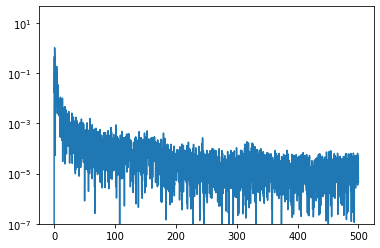

In [3]:
fxx, Pxx = signal.periodogram(x_tt, fs=f_sampling)
plt.semilogy(fxx, Pxx)
plt.ylim(1e-7)

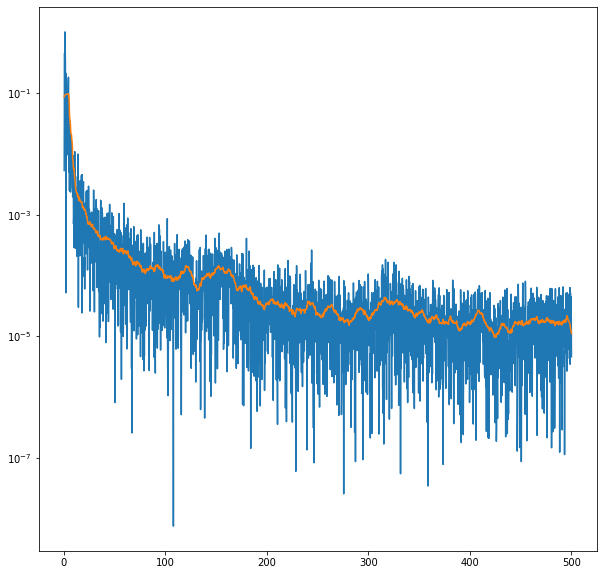

In [4]:
log_psd = -np.log10(Pxx)
size = 20
to_conv = [1/(2*size + 1)] * (2 * size + 1)
clean_psd = np.convolve(Pxx[1:], to_conv)
plt.figure(figsize=(10,10))
plt.semilogy(fxx[1:], Pxx[1:])
plt.semilogy(fxx[1:], clean_psd[size:-size])

clean_psd = clean_psd[size-1:-size]

In [5]:
#stats.linregress(fxx[np.where(fxx < 0.1)], np.log10(clean_psd[np.where(fxx < 0.1)]))

In [6]:
c = stats.linregress(np.log10(fxx[np.where(fxx > 0.1)]), np.log10(clean_psd[np.where(fxx > 0.1)])).slope

In [7]:
a = 1e-6
get_ft = lambda b, fc, c: b/((1j * fxx + a)**(1/3) * (1j * fxx + fc)**(-c/2 - 1/3))

def cost(pars):
    b, fc, c = pars
    return np.mean((np.log10(np.abs(get_ft(b, fc, c))**2) - np.log10(Pxx))**2)

b, fc, c = optimize.minimize(cost, [1, 10, c]).x
print(b, fc, c)

0.19211209495344092 10.335474192520474 -1.3740386545314627


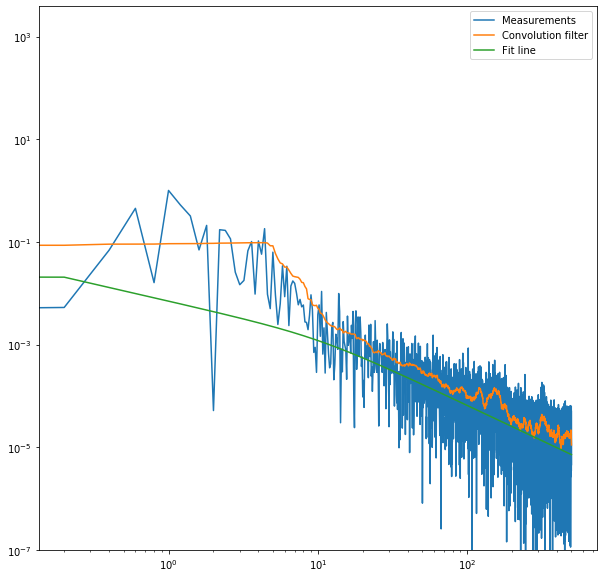

In [8]:
plt.figure(figsize=(10,10))
plt.loglog(fxx, Pxx, label='Measurements')
plt.loglog(fxx, clean_psd, label='Convolution filter')
plt.loglog(fxx, np.abs(get_ft(b, fc, c))**2, label='Fit line')
plt.ylim(1e-7)
plt.legend()

In [9]:
ft = lambda f: b/((1j * f + a)**(1/3) * (1j * f + fc)**(-c/2 - 1/3))

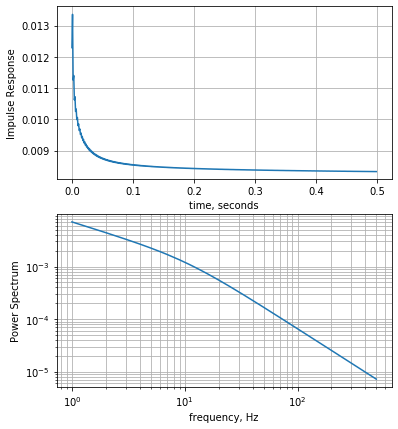

In [14]:
impulse_track = design_filt(dt=1e-3, N=N, tf=lambda f: 1/ft(f), plot=False)
impulse_correct = design_filt(dt=1e-3, N=2*N, tf=ft)

In [15]:
complex_impulse = impulse_correct
#impulse = np.real(complex_impulse)/sum(np.real(complex_impulse))
impulse = np.real(complex_impulse)

In [16]:
def make_impulse_filter(x):
    # takes in np array x: the impulse response of a filter
    # returns matrices A, P, Q, H, R to augment with the kfilter
    n = x.size
    print(n)
    A = np.zeros((n, n))
    for i in range(1, n):
        A[i][i-1] = 1
    A[0] = np.flip(np.real(x))
    # when you start the filter, make sure to start it at time n with the first n measurements identically
    P = np.zeros((n,n))
    Q = np.zeros((n,n))
    Q[0][0] = 1
    H = np.zeros((1,n))
    H[:,0] = 1
    R = np.array([0.06**2])
    return A, P, Q, H, R

A, P, Q, H, R = make_impulse_filter(impulse/sum(impulse))

500


In [17]:
# now, let's Kalman filter with this
measurements = x_tt + np.random.normal(0, 0.06, x_tt.shape)
state = measurements[:N]
rms = lambda data: np.sqrt(np.mean(data ** 2))
kfiltered, predictions = kfilter((state, A, P, Q, H, R), measurements[N:lim], physics=True)

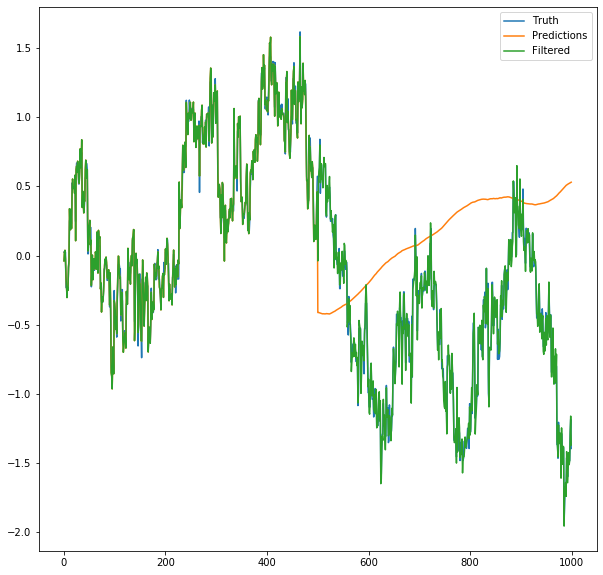

In [18]:
plt.figure(figsize=(10,10))
filtered = np.hstack((measurements[:N], kfiltered))
plt.plot(x_tt[:lim], label='Truth')
#plt.plot(measurements[:lim], label='Measurements')
plt.plot(np.hstack((measurements[:N], -predictions)), label='Predictions')
plt.plot(filtered, label='Filtered')
residual = filtered - x_tt[:lim]
#plt.plot(residual, label='Residual')
plt.legend()

(1e-07, 50.75476773424492)

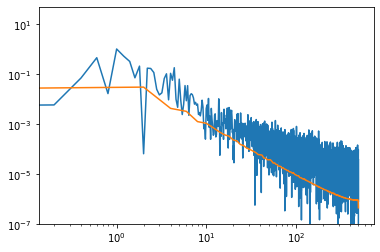

In [19]:
plt.loglog(*signal.periodogram(measurements, fs=f_sampling))
plt.loglog(*signal.periodogram(predictions, fs=f_sampling))
plt.ylim(1e-7)

In [20]:
rms(residual[750:])

0.056855842428497685

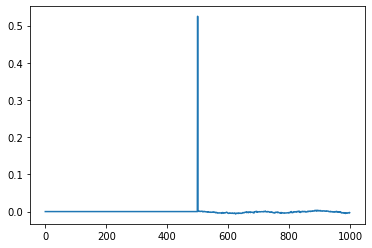

In [21]:
# the 'are you just tracking measurements' plot
plt.plot(measurements[:lim] - filtered[:lim])

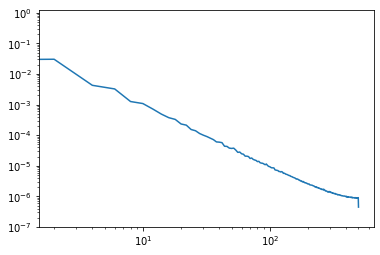

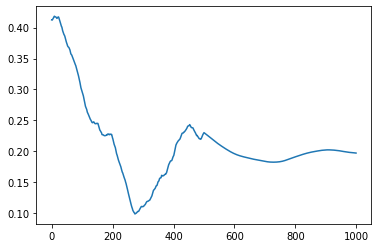

In [22]:
state = measurements[:N]
size = 1000
predictions_nonloop = np.zeros(size,)
for i in range(size):
    state = A.dot(state)
    predictions_nonloop[i] = H.dot(state)
    
plt.loglog(*signal.periodogram(predictions, fs=f_sampling))
plt.ylim(1e-7)
plt.show()
plt.plot(predictions_nonloop)

In [ ]:
tt_noisy = measurements
steps = measurements.size
commands = np.zeros(steps)
centroid = np.zeros(steps)

for i in range(steps):
    if i >= 4:
        commands[i-1] = 0.6*commands[i-2] + 0.32*commands[i-3] + 0.08*commands[i-4] + 0.1*centroid[i-1]
    centroid[i] = tt_noisy[i] - commands[i-1]
    
plt.plot(centroid, label='Controlled')
plt.plot(x_tt, label='Truth')
plt.legend()
rms(centroid)